# 1) Description and Source of Data

https://storage.googleapis.com/open-targets-data-releases/21.02/output/21.02_association_data.json.gz 

This dataset is all about the rational link to the disease and originates from the open targets platform. It  was downloaded from the web using wget of the GNU project. Open targets also has a well-documented API that is most suitable when interested in only a small part of the data. However, as we were interested in the whole dataset - we did not make use of open targets API. 
The complete dataset contains ~7.4M observations from ~14k different diseases that were linked through 19 different data sources with around 27k target genes.


### 1.1) Mount google drive to colab

In [1]:
# mount google drive to colab
from google.colab import drive
import os
n = 140
drive.mount('/content/drive')
print("#" * n)

# change working directory
print("### colabs default working directory")

print("###\n### path: {}".format(os.getcwd()))
print("#" * n)
print("### setted working directory")

%cd drive/Shareddrives/MADS_Milestone1/

print("###\n### {}".format(os.getcwd()))
print("#" * n)



Mounted at /content/drive
############################################################################################################################################
### colabs default working directory
###
### path: /content
############################################################################################################################################
### setted working directory
/content/drive/Shareddrives/MADS_Milestone1
###
### /content/drive/Shareddrives/MADS_Milestone1
############################################################################################################################################


**Strategy**

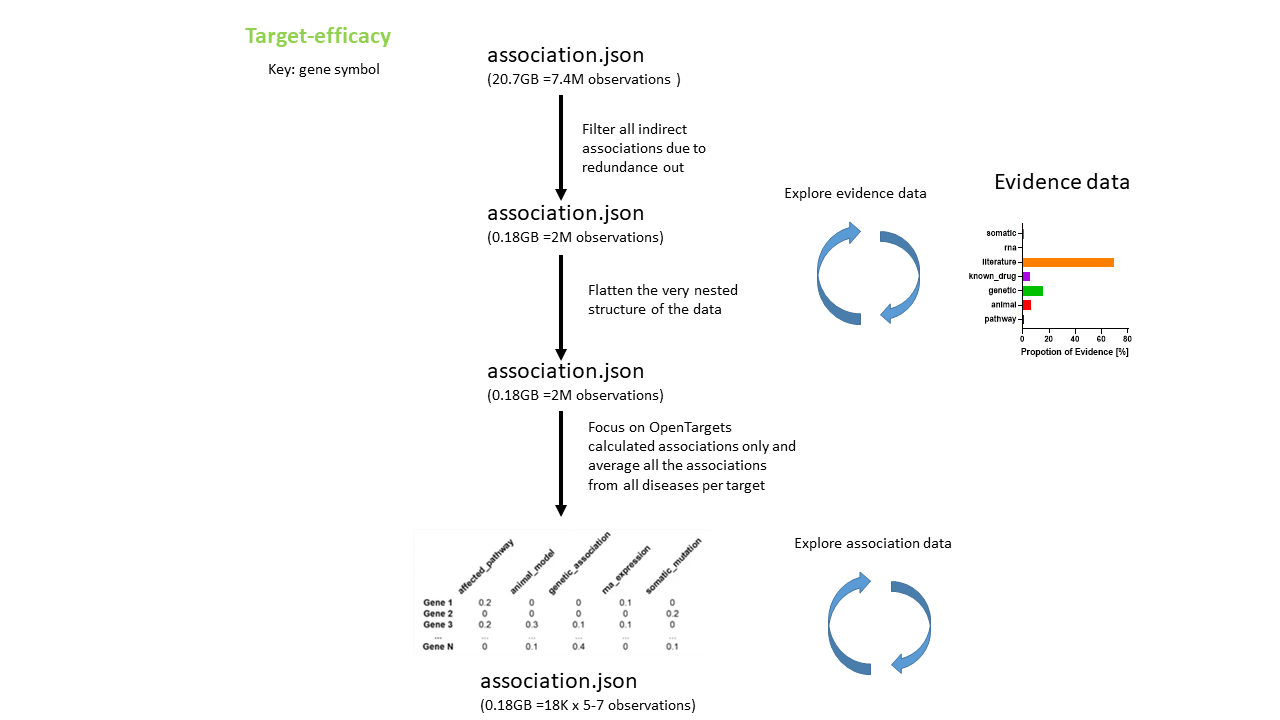

In [2]:
from IPython.display import Image
Image('Visualizations/association.png', width=900, height=500)


### 1.2) Catch all files in directory

In [3]:
import subprocess
import re

# define the ls command to find all results
ls = subprocess.Popen(["ls", "-p", "./Raw_Assets"],
                      stdout=subprocess.PIPE,
                     )

# define the grep command to exclude all folders
grep = subprocess.Popen(["grep", "-v", "/$"],
                        stdin=ls.stdout,
                        stdout=subprocess.PIPE,
                        )

# read from the end of the pipe (stdout)
endOfPipe = grep.stdout

json = {}
txt = {}
csv = {}
gmt = {}
all = []
path = "Raw_Assets/"
# output the files line by line
for line in endOfPipe:  
    
    w = re.sub( "\\\\n'$", "", str(line))
    w = re.sub("^b'", "", w)
    front = re.sub("\d+.", "", w)
    name = re.sub("\..*", "", front)

    all.append(w)
    if ".json" in w:        
        json[name] = path + w
    elif ".txt" in w or ".tsv" in w:
        txt[name] = path + w
    elif ".csv" in w:
        csv[name] = path + w
    else:
        gmt[name] = path + w
    
    
    
#     if (w[0] == "C") | (w[0] == "D"):
#         colnames.append(w)

In [4]:
json

{'association_data': 'Raw_Assets/21.02_association_data.json'}

### 1.3) Download association dataset from Open Targets Platform


The [Open Targets Platform](https://www.opentargets.org/) is a comprehensive tool that supports systematic identification and prioritisation of potential therapeutic drug targets.

By integrating publicly available datasets including data generated by the Open Targets consortium, the Platform builds and scores target-disease associations to assist in drug target identification and prioritisation. It also integrates relevant annotation information about targets, diseases, phenotypes, and drugs, as well as their most relevant relationships.

The Platform is a freely available resource that is actively maintained with bi-monthly data updates. Data is available through an intuitive user interface, an API, and data downloads. The pipeline and infrastructure codebases are open-source and the licence allows the creation of self-hosted private instances of the Platform with custom data.

As we are interested in the whole database which OpenTargets is using we have downloaded the whole dataset using wget instead of using the API

In [ ]:
import os

n = 80
if "association_data" not in json.keys():
  # download STRING interactome of human protein
  print("#"* n)
  print("### Download human protein interactome file to working directory") 
  print("#"* n)
  print("### path: {}".format(os.getcwd()))
  print("#"* n)
  %cd Raw_Assets/
  
  !wget https://storage.googleapis.com/open-targets-data-releases/21.02/output/21.02_association_data.json.gz
  
  %cd ../
else: 
  print("#"* n)
  print("### file already exists in working directory")
  print("#"* n)
  print("### path: {}\n### sub-directory: {}".format(os.getcwd(), json["association_data"]))
  
  print("###\n### --> no need to download it again!")
  print("#"* n)
  

################################################################################
### file already exists in working directory
################################################################################
### path: /content/drive/Shareddrives/MADS_Milestone1
### sub-directory: Raw_Assets/21.02_association_data.json
###
### --> no need to download it again!
################################################################################


# 2) Infer target engagment by mining the association dataset

### 2.1) import libraires

In [5]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None) # Setting max number of dataframe rows to show
pd.set_option('display.max_columns', None) # Setting max number of dataframe cols to show
import matplotlib.pyplot as plt

# to check existence of module
import importlib
exist_pyspark = importlib.util.find_spec("pyspark")
if exist_pyspark is None:
      !pip install pyspark
      
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *


     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 198 kB 56.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=7eea1f2611e6f7777cc1d7420b70b3d34cab02926ae9b66d50483985a5d3ca5d
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


## 2.2) Import Association dataset

creat SparkSession --> not possible to work in pandas because it takes up too much RAM (therefore crashes due to 13GB limit in colab)



In [6]:
# create spark session with all available cores
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('Milestone_I') \
    .getOrCreate() 

sc = spark.sparkContext

In [7]:
# read association file in
asso = spark.read.json(json["association_data"])


## 2.3) Properties of dataset

In [9]:
from pyspark.sql.functions import isnan, when, count, col
n = 50

# there are 5'375'689 indirect and 2'009'499 direct associations between target and disease
# resulting in 7'385'188 total associations -using asso.counts() - takes too much time 
# and do not need exact count therefore use rather asso.rdd.countApprox(timeout=800)

total_r = 7385188 # asso.rdd.countApprox(timeout=800) - also this takes to much time use hard coded number as it was calculated once using the exact count functon .count()
dir_r = 2009499 # asso.filter("is_direct").rdd.countApprox(timeout=800)
COL = asso.columns
null = asso.select([count(when(col(c).isNull(), c)).alias(c) for c in COL])

print("#"*n)
print("### Column names:\n### {}".format(COL))
print("#"*n)
print("### Total number of all target-disease pairs:\n### {}M".format(round(total_r/1000000, 1)))
print("#"*n)
print("### Total number of direct target-disease pairs:\n### {}M".format(round(dir_r/1000000, 1)))
print("#"*n)
print("### Total number of indirect target-disease pairs:\n### {}M".format(round((total_r-dir_r)/1000000, 1)))
print("#"*n)
print("### Number of missing values:")
null.show()
print("#"*n)
print("### Nested data structure:")
asso.printSchema()


##################################################
### Column names:
### ['association_score', 'disease', 'evidence_count', 'id', 'is_direct', 'target']
##################################################
### Total number of all target-disease pairs:
### 7.4M
##################################################
### Total number of direct target-disease pairs:
### 2.0M
##################################################
### Total number of indirect target-disease pairs:
### 5.4M
##################################################
### Number of missing values:
+-----------------+-------+--------------+---+---------+------+
|association_score|disease|evidence_count| id|is_direct|target|
+-----------------+-------+--------------+---+---------+------+
|                0|      0|             0|  0|        0|     0|
+-----------------+-------+--------------+---+---------+------+

##################################################
### Nested data structure:
root
 |-- association_score: struct (null

## 2.4) Findings and follow-ups

2.4.1) The platform stores both direct and indirect associations between genes and diseases, with the indirect associations representing associations between genes and parent terms in the ontology. There are 7.4M observations with about 2M direct and 5.4M indirect associations between a target and a disease. Since we are interested in the overall target and not in the specific target in the context of the disease, we need to average all the associations for each target over all diseases. To avoid artificially increasing scores or counting evidence more than once because the indirect associations are just [propagated](https://academic.oup.com/nar/article/45/D1/D985/2605745) from the direct associations and are redundant therefore, we need to remove all indirect associations


2.4.2) The data structure is strongly nested.
  
- For convenience, the dataset needs to be flattened.

2.4.3) There are no missing values on the highest level of the datastructure
- No action needed.
 

### 2.4.1) Remove redundant indirect associations

In [10]:
asso = asso.filter("is_direct")

### 2.4.2) Flatten the data structure

define a function that flattens the spark dataframe for convenience

In [ ]:
from pyspark.sql.functions import col

def flatten_df(nested_df):
    stack = [((), nested_df)]
    columns = []

    while len(stack) > 0:
        parents, df = stack.pop()

        flat_cols = [
            col(".".join(parents + (c[0],))).alias("_".join(parents + (c[0],)))
            for c in df.dtypes
            if c[1][:6] != "struct"
        ]

        nested_cols = [
            c[0]
            for c in df.dtypes
            if c[1][:6] == "struct"
        ]

        columns.extend(flat_cols)

        for nested_col in nested_cols:
            projected_df = df.select(nested_col + ".*")
            stack.append((parents + (nested_col,), projected_df))

    return nested_df.select(columns)

In [ ]:
flat_asso = flatten_df(asso)
print("#" * 50)
print("### After flattening there are {} columns".format(len(flat_asso.columns)))
print("#" * 50)
flat_asso.printSchema()

##################################################
### After flattening there are 84 columns
##################################################
root
 |-- id: string (nullable = true)
 |-- is_direct: boolean (nullable = true)
 |-- target_id: string (nullable = true)
 |-- target_tractability_smallmolecule_buckets: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- target_tractability_smallmolecule_high_quality_compounds: long (nullable = true)
 |-- target_tractability_smallmolecule_small_molecule_genome_member: boolean (nullable = true)
 |-- target_tractability_smallmolecule_top_category: string (nullable = true)
 |-- target_tractability_smallmolecule_categories_clinical_precedence: double (nullable = true)
 |-- target_tractability_smallmolecule_categories_discovery_precedence: double (nullable = true)
 |-- target_tractability_smallmolecule_categories_predicted_tractable: double (nullable = true)
 |-- target_tractability_other_modalities_buckets: array (nullable =

In [ ]:
flat_asso.columns

['id',
 'is_direct',
 'target_id',
 'target_tractability_smallmolecule_buckets',
 'target_tractability_smallmolecule_high_quality_compounds',
 'target_tractability_smallmolecule_small_molecule_genome_member',
 'target_tractability_smallmolecule_top_category',
 'target_tractability_smallmolecule_categories_clinical_precedence',
 'target_tractability_smallmolecule_categories_discovery_precedence',
 'target_tractability_smallmolecule_categories_predicted_tractable',
 'target_tractability_other_modalities_buckets',
 'target_tractability_other_modalities_categories_clinical_precedence',
 'target_tractability_antibody_buckets',
 'target_tractability_antibody_top_category',
 'target_tractability_antibody_categories_clinical_precedence',
 'target_tractability_antibody_categories_predicted_tractable_high_confidence',
 'target_tractability_antibody_categories_predicted_tractable_med_low_confidence',
 'target_gene_info_name',
 'target_gene_info_symbol',
 'evidence_count_total',
 'evidence_count_d

We can see that there are 84 features from which we identified three layers of features that are of main interest to focus for our project:

1) Anything that is about the target identity such as id, gene name, gene symbol.

2) Anything about target tractability/druggability potential.

3) Anything about the direct association scores that already include all the evidence.

We will focus on the following features:


In [ ]:
keep = [
        'id', 
        'target_id', 
        'target_gene_info_name', 
        'target_gene_info_symbol', 

        'target_tractability_smallmolecule_buckets',
        'target_tractability_other_modalities_buckets',
        'target_tractability_antibody_buckets',

        'association_score_overall',
        'association_score_datatypes_affected_pathway',
        'association_score_datatypes_animal_model',
        'association_score_datatypes_genetic_association',
        'association_score_datatypes_literature',
        'association_score_datatypes_rna_expression',
        'association_score_datatypes_somatic_mutation'
        ]
  
df = flat_asso.select(keep)

Down-sampling of the pyspark dataframe to get some examples which I can use to produce the functions. I'm going to apply on the whole dataset later to make things faster.

In [ ]:
# sampling the data down to get some examples which i can use to produce the functions 
# Im going to apply on the whole dataset later to make things faster

df_sample = df.sample(fraction = 1/100000, seed=42)
df_sample.show() # 18 rows :-P

+--------------------+---------------+---------------------+-----------------------+-----------------------------------------+--------------------------------------------+------------------------------------+-------------------------+--------------------------------------------+----------------------------------------+-----------------------------------------------+--------------------------------------+------------------------------------------+--------------------------------------------+
|                  id|      target_id|target_gene_info_name|target_gene_info_symbol|target_tractability_smallmolecule_buckets|target_tractability_other_modalities_buckets|target_tractability_antibody_buckets|association_score_overall|association_score_datatypes_affected_pathway|association_score_datatypes_animal_model|association_score_datatypes_genetic_association|association_score_datatypes_literature|association_score_datatypes_rna_expression|association_score_datatypes_somatic_mutation|
+-------

## 2.5) Average association scores for each target gene across each disease 


In order to remove the target/gene to disease pair relation we are going to average all the different association scores across all the diseases 

This is a very aggressive manipulation of which we are aware of. For example, it may under or over score a certain target that is explored in multiple or in fewer diseases. We will keep that in mind!

*EDIT: Next time we would like to remove all the Oncological disease as we find that they are very likely quiet distinct from other diseases - especially when it comes to the willingness to risk safety issues as it is a very severe disease from which we often talk about months or years to prolong a life and therefore risk some more side effects*

In [ ]:
from pyspark.sql import Window
import pyspark.sql.functions as F

# expression to average within each association score column
exprs = [F.avg(col(c)) for c in keep[7:14] ]
# groupby each target gene and average association score columns across diseases
asso_avg = df.groupby('target_gene_info_symbol').agg(*exprs)
# transform pyspark dataframe to pandas dataframe -> dataset was reduced to 27'472 target genes of which not all are protein coding
# as we know there are only 19'331 official gene symbols https://www.genenames.org/tools/search/#!/?query=&rows=20&start=0&filter=document_type:gene
asso_avg = asso_avg.toPandas()
asso_avg.columns = asso_avg.columns.str.replace("avg\(association_score_*", "").str.replace("datatypes_", "").str.replace("\)", "_score")

asso_avg.head()

,target_gene_info_symbol,overall_score,affected_pathway_score,animal_model_score,genetic_association_score,literature_score,rna_expression_score,somatic_mutation_score
0,NF1,0.346749,0.043544,0.055043,0.138956,0.027207,0.000016,0.219218
1,ABCC6,0.224391,0.070588,0.087401,0.155794,0.016307,0.001947,0.000000
2,AKT2,0.405630,0.052861,0.078375,0.021072,0.019325,0.000011,0.299032
3,NSDHL,0.252277,0.000000,0.199878,0.054635,0.003064,0.000286,0.000000
4,RNASET2,0.187137,0.000000,0.020483,0.161549,0.012771,0.001435,0.000000


## 2.6) transform the tractability/druggability buckets to a tractability/drugability score for small molecules, antibodies and other modalities 

Each tractability bucket column in the dataset is a list of integers that defines a category (see tractability_score function below for translations) for each target-disease pair. 

As we are interested in the overall tractability independent of the disease, we need to concatenate the lists for each target gene across the diseases before converting the buckets into one score. This is done by using the F.collect_list() (extends each category - alternative is collect_set() - takes only unique categories). However, this approach would lead to a nested list. therefore we are going to use F.flatten() to produce a flat list that can be used for our tractability_score function

In [ ]:
def tractability_score(tract_list):
  """This function converts the drugability/tractability buckets to one drugability/tractability score for each target
  by averaging the weigthed tractability buckets
  
1 = Targets with drugs in phase IV
2 = Targets with drugs in phase II or phase III
3 = Targets with drugs in phase 0 or phase I

4 = Targets with crystal structures with ligands (excluding: buffer compounds, solvents, crystallization agents/additives and sugars) 
5 = Targets with high quality ligands (PFI ≤7, structural_alerts ≤2, pchembl_value ≥5.5 or equivalent activity measure)

6 = Targets with a drugEBIlity score equal or greater than 0.7
7 = Targets with drugEBIlity between 0 and 0.7 (Targets with predicted Signal Peptide or Trans-membrane regions, and not destined to organelles)

8 = Targets considered druggable by Finan et al. 2017

9 = N.A. (Targets with main location “Plasma membrane” - high confidence)

Thereby the buckets are split into four weigthiings
- clinical precedence: buckets 1, 2, and 3 = [1, 0.95, 0.9]
- discovery precedence: buckets 4 and 5 = [0.7, 0.65]
- predictable tractable: buckets 6, 7, and 8 = [0.4, 0.35, 0.3]
- less confident predictable buckets: 9 = 0.1
- anything else: = 0

input:

@param tract_list: a list of drugability/tractability bucket categories which are integers between 1 and 9 or missing values

output:

returns the one averaged drugability/tractability score

"""
  n = len(tract_list)
  if n != 0:
    weigthings = {1: 1, 2: 0.95, 3: 0.9, 4: 0.7, 5: 0.65, 6: 0.4, 7: 0.35, 8: 0.3, 9: 0.1}
    return np.sum([weigthings.get(x, 0) for x in tract_list]) / len(tract_list)
  else:
    return 0.


  

In [ ]:
# one example
tractability_score([1,2,5,4,3,2,4,5])


0.8125

In [ ]:
# Target tractability 
# https://docs.targetvalidation.org/getting-started/target-tractability
# 1,2,3 = clinical precedence
# 4,5 = discovery precedence
# 6,7,8 = predictable tractable

# concatenates all the bucket lists for each target gene across diseases
asso_tract = df.groupBy('target_gene_info_symbol').agg(*[F.flatten(F.collect_list(c)).alias(c) for c in keep[4:7]])
# converts the dataset to a pandas Dataframe --> reduced dataset to 27'472
asso_tract = asso_tract.toPandas()

# split gene symbol and tractability bucket lists
index = asso_tract[["target_gene_info_symbol"]]
# vectorize the tractability_score function on each row per column to convert the buckets to one score
tract_scores = asso_tract[keep[4:7]].apply(np.vectorize(tractability_score))
# merge the gene symbols back to the dataset
tract_scores = index.merge(tract_scores, left_index=True, right_index=True)

# clean the column names
tract_scores.columns = ['target_gene_info_symbol', 'druggability_score_smallmolecule',
       'druggability_score_other_modalities',
       'druggability_score_antibody']
tract_scores.head()

,target_gene_info_symbol,druggability_score_smallmolecule,druggability_score_other_modalities,druggability_score_antibody
0,AARS1,0.7,0.0,0.00
1,ABCC6,0.5,0.0,0.45
2,AC006013.1,0.0,0.0,0.00
3,AC010609.1,0.0,0.0,0.00
4,AC011632.2,0.0,0.0,0.00


## 2.7) Merge the association and tractability scores to one dataset

In [ ]:
asso_final = asso_avg.merge(tract_scores, on="target_gene_info_symbol")
print(asso_final.shape)
asso_final.head()

(27472, 11)


,target_gene_info_symbol,overall_score,affected_pathway_score,animal_model_score,genetic_association_score,literature_score,rna_expression_score,somatic_mutation_score,druggability_score_smallmolecule,druggability_score_other_modalities,druggability_score_antibody
0,NF1,0.346749,0.043544,0.055043,0.138956,0.027207,0.000016,0.219218,0.55,0.0,0.000000
1,ABCC6,0.224391,0.070588,0.087401,0.155794,0.016307,0.001947,0.000000,0.50,0.0,0.450000
2,AKT2,0.405630,0.052861,0.078375,0.021072,0.019325,0.000011,0.299032,0.60,0.0,0.525000
3,NSDHL,0.252277,0.000000,0.199878,0.054635,0.003064,0.000286,0.000000,0.50,0.0,0.350000
4,RNASET2,0.187137,0.000000,0.020483,0.161549,0.012771,0.001435,0.000000,0.00,0.0,0.566667


## 2.8) Export final association dataset

In [ ]:
# export aggregated data
#display(asso_final.describe())
asso_final.to_csv("Intermediate_Assets/target_association.csv")

One comments:

We have also explored the evidence for all the associations by looking at the distributions across the evidence measures. However, because of story flow we did not include it here. but as high-level insight It was heavily screed to the literature

**not relevant**

In [ ]:
df = pd.read_csv(csv["averaged_association"])

df.columns = df.columns.str.replace("avg\(association_score_*", "").str.replace("datatypes_", "").str.replace("\)", "_score")
df.set_index("target_id", inplace=True)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()


,overall_score,affected_pathway_score,animal_model_score,genetic_association_score,literature_score,rna_expression_score,somatic_mutation_score
target_id,,,,,,,
ENSG00000119888,0.123691,0.010526,0.040424,0.039594,0.033537,0.001908,0.000000
ENSG00000115705,0.151166,0.021089,0.067094,0.041702,0.025973,0.000261,0.000000
ENSG00000171302,0.286150,0.000000,0.067939,0.028552,0.007700,0.000311,0.192736
ENSG00000163254,0.172730,0.000000,0.135521,0.053588,0.003354,0.000000,0.000000
ENSG00000175097,0.198597,0.023176,0.123121,0.064830,0.011895,0.000000,0.000000


In [ ]:
txt

{}

## Label file (ground truth)
#### unusual txt format needs to be shaped into a pandas dataframe

,TARGETID,TARGNAME,TARGTYPE,UNIPROID
T00032,T00032,Osteopontin (SPP1),Research target,OSTP_HUMAN
T00033,T00033,Transforming growth factor alpha (TGFA),Clinical Trial target,TGFA_HUMAN
T00037,T00037,Fungal Sterol 24-C-methyltransferase (Fung erg6),Research target,ERG6_PNEC8
T00039,T00039,CTGF messenger RNA (CTGF mRNA),Clinical Trial target,CTGF_HUMAN
T00075,T00075,CDC42 binding protein kinase alpha (DMPK-like ...,Research target,MRCKA_HUMAN


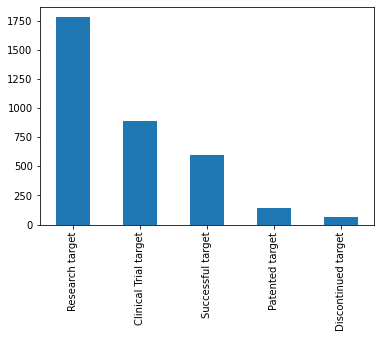

In [ ]:
label = pd.read_table(txt['PTTD_uniprot_all'], skiprows=21, header=0)
label = label.unstack().T.reset_index(level=[0], drop=True).T
label["TARGTYPE"].value_counts().plot.bar()
label.head()




### need to convert gene symbols to ensembl ids to join it with the association dataset

In [ ]:
!pip install mygene
import mygene

In [ ]:
# generate connection to mygene API
mg = mygene.MyGeneInfo()
# clean gene symbols in a way that is convertable
label["SYMBOL"] = list(map(str.upper, label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")))
label.SYMBOL
# query for all the gene symbols in humans only
q = mg.querymany(label.SYMBOL, scopes="symbol", fields="symbol,ensembl,alias", species="human", returnall=True)

# from 1034 of 3473 genes were not found --> try to improve it via gene synonyms 
# 123 genes showed duplicats

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',


In [ ]:
def symbol_ensembl_converter(query=q):
  l={}
  # loop through all 3'475 queries (gene symbols from dataframe)
  for i in query["out"]:
    # catch all the dict items
    # loop through items
    key = [k for k in i.keys()]
    value = [v for v in i.values()]
     
    if "query" in key:
      a = value[key.index("query")]
    else:
      a = "no-query"
    
    if "ensembl" in key:
      try:
        b = value[key.index("ensembl")]["gene"]
        l[a] = b
      except:
        b = value[key.index("ensembl")][0]["gene"]
        l[a] = b

    else:    
      b = "no-ensembl"
      l[a] = b
      
    if 'notfound' in key:
  
      b = "not-found"
      l[a] = b  
  return l



l = symbol_ensembl_converter()

conversion_count = pd.DataFrame([l]).T.value_counts().value_counts().reset_index(
    ).rename(index={0: "unique-ensembl", 1: "not-found", 2: "no-ensembl"}
             ).apply(lambda x: np.sum(x)-1, axis=1
                     )

ax = conversion_count.plot.bar()
ax.set_ylim(0,3000)
for p in ax.patches:
  ax.annotate(str(round(p.get_height(),0)), (p.get_x() + 0.2, (p.get_height() + 100) * 1.05 ))

NameError: ignored

In [ ]:
"""there are {} unique gene symbols from which i have returned {} gene symbols after the mapping resulting in {} missing gene symbols. However, of these {} genes {} were not found and {} were found but do not have an ensemblID""".format(len(set(label.SYMBOL)), len(set(l)), len(set(label.SYMBOL)) - len(set(l)), len(set(l)), conversion_count["not-found"], conversion_count["no-ensembl"] )

'there are 2956 unique gene symbols from which i have returned 2956 gene symbols after the mapping resulting in 0 missing gene symbols. However, of these 2956 genes 649 were not found and 3 were found but do not have an ensemblID'

### try to convert some more gene symbols to ensemblID using gene synonyms

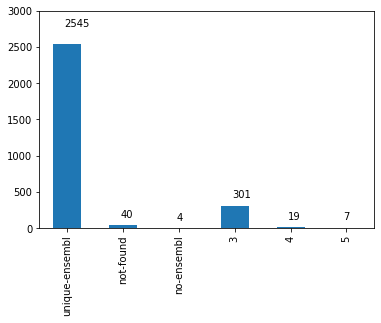

In [ ]:
not_found = [k for k,v in l.items() if "E" not in v]
not_found

def convert_symbol_synonyms(not_found=not_found, l=l, species = "human"):
  
  for gene in not_found:
    if "/" not in gene:
      # then try to query for the gene synonyms if available
      Q = mg.query(gene, scopes="symbol", fields="symbol,ensembl,alias", 
                   species=species)
      

      if Q["hits"] == []:
        l[gene] = "not-found"
        
      # loop through all gene synonym queries
      for L in Q["hits"]:
        key = [k for k in L.keys()]
        value = [v for v in L.values()]
        # check if the gene symbol of the query was assigned as exact synonym match
        if "alias" in key:
          if gene in value[key.index("alias")]:
            # check if that gene synonym also contain a ensemblID
            if "ensembl" in key:
              #print(value2[key2.index("ensembl")])
              # if it has an ensemblID check if it is a list or a dict
              if isinstance(value[key.index("ensembl")], list):
                  # store the ensemblID
                  #print(a, v, ind, Q["hits"][ind]["ensembl"][0])#["ensembl"]["gene"])
                b = value[key.index("ensembl")][0]["gene"]
                l[gene] = b
                
              else:
                  # if the ensembl is a dict instead of a list
                  #print(a, v, ind, Q["hits"][ind]["ensembl"]["gene"])
                b = value[key.index("ensembl")]["gene"]
                l[gene] = b
                
            else:
                # if the gene synonym was found but there was not ensemblID
                #print(a, v, ind, Q["hits"][ind].keys())
                l[gene] = "no-ensembl"
            
    else:
      # not found due to "/" in gene symbol breaks query
     l[gene] = "break-query'/'"

  return l

m = convert_symbol_synonyms()

conversion_synonym_count  = pd.DataFrame([m]).T.value_counts().value_counts().reset_index(
    ).rename(index={0: "unique-ensembl", 1: "duplicated-ensembl", 2: "triplicated-ensembl", 3: "not-found", 4: "query break '/'", 5: "no-ensembl"}
             ).apply(lambda x: np.sum(x)-1, axis=1
                     ) 
             
conversion_synonym_count.iloc[[1,2]] = conversion_synonym_count.iloc[[1,2]] + [-1, -2]

ax = conversion_synonym_count.plot.bar()
ax.set_ylim(0,3000)
for p in ax.patches:
  ax.annotate(str(round(p.get_height(),0)), (p.get_x() + 0.2, (p.get_height() + 100) * 1.05 ))


In [ ]:
m 

entrez = [(k,v) for k,v in m.items() if v.isdigit()] 

mg.getgene(entrez[0][1], fields="symbol,ensembl") # --> not showing ensemblID but entrezID 
# manually add"ENSG00000168078"
m[entrez[0][0]] = "ENSG00000168078"


In [ ]:
pd.Series([conversion_synonym_count["unique-ensembl"] + conversion_synonym_count["duplicated-ensembl"] + conversion_synonym_count["triplicated-ensembl"],
conversion_synonym_count["not-found"] + conversion_synonym_count["duplicated-ensembl"] + 2*conversion_synonym_count["triplicated-ensembl"] + conversion_synonym_count["query break '/'"],
conversion_synonym_count["no-ensembl"]], index=["ensembl", "no-found", "no-ensembl"])


ensembl       2586
no-found       363
no-ensembl       7
dtype: int64

In [ ]:
label["ensembl"] = label.SYMBOL.replace(m)
# not found 675
# break query / 19
# ENS 7
# no-ensembl 7
# Ensg 4, 3, 2, 1

label.to_csv("ground_truth.csv")
stats = label.ensembl.value_counts().value_counts().reset_index().rename(index={0: "unique-ensembl", 1: "duplicated-ensembl", 2: "triplicated-ensembl", 
                                                          3: "not-ensembl/7xENSG", 4: "not-found", 5: "query break '/'", 6: "quadriplicate-ensembl"}
             ).apply(lambda x: np.sum(x) - 1, axis=1)
stats[["duplicated-ensembl", "triplicated-ensembl", "not-ensembl/7xENSG", "quadriplicate-ensembl"]] = stats[["duplicated-ensembl", "triplicated-ensembl", "not-ensembl/7xENSG", "quadriplicate-ensembl"]] - [1,2,7, 3]

pd.Series([stats["unique-ensembl"] + stats["duplicated-ensembl"] + stats["triplicated-ensembl"] + stats["quadriplicate-ensembl"] + stats["not-ensembl/7xENSG"],
           stats["not-found"] + stats["duplicated-ensembl"] + stats["triplicated-ensembl"]*2 + stats["quadriplicate-ensembl"]*3 + stats["not-ensembl/7xENSG"] * 7 +6 + stats["query break '/'"]], index=["ensembl", "not-found"])


ensembl      2586
not-found     887
dtype: int64

In [ ]:
2586+887 - len(label.SYMBOL)

0

In [ ]:
label.ensembl.replace({"break-query'/'": "not-found", "no-ensembl": "not-found"}, inplace=True)
label.groupby("TARGTYPE").apply(lambda x: x["ensembl"].value_counts().value_counts())

TARGTYPE                  
Clinical Trial target  1       693
                       2        24
                       3         2
                       145       1
Discontinued target    1        51
                       17        1
Patented target        1       104
                       2         2
                       27        1
                       6         1
Research target        1      1335
                       2        30
                       383       1
Successful target      1       453
                       2         6
                       129       1
Name: ensembl, dtype: int64

## merge association, centrality score and ground truth data

In [ ]:


def convert_any_to_Symbol(ensembl=  ['ENSP00000000233', 
                                              'ENSP00000272298', 
                                              'ENSP00000253401'],
                                   which_ensembl = ['ensembl.protein', 
                                                    'ensembl.gene', 
                                                    'ensembl.transcript',
                                                    'entrezgene'][0], 
                                   species="human"):
  
  # check if mygene module is already installed
  import importlib
  exist_mygene = importlib.util.find_spec("mygene")
  
  if exist_mygene is None:
      !pip install mygene
  
  # import mygene module
  import mygene

  # set the connection to the mygene API
  mg = mygene.MyGeneInfo()
  # create the query
  q = mg.querymany(ensembl, scopes=which_ensembl, fields="ensembl,symbol", 
                   species=species, returnall=True)
  
  
  print("#######################################################################################\nmissiging queries")
  print(q["missing"])
  
  print("#######################################################################################\nduplicated queries")

  print(q["dup"])
  
  conv = {}
  n= 0
  for v, i in zip(ensembl, q["out"]):
    #print(n, i)
    #n += 1
    if isinstance(i, list):
      if i != []:    
        if "symbol" in i[0].keys():
          
          conv[v] = i[0]["symbol"]
        else:
          
          conv[v] = "no-symbol"
      else:
        conv[v] = "not-found"
    else: 
      if "symbol" in i.keys():
        conv[v] = i["symbol"]
      else:
        
        conv[v] = "no-symbol"
  print("#######################################################################################\nconverted queries")

  print(conv)
  return conv

conv = convert_any_to_Symbol()

querying 1-3...done.
Finished.
#######################################################################################
missiging queries
[]
#######################################################################################
duplicated queries
[]
#######################################################################################
converted queries
{'ENSP00000000233': 'ARF5', 'ENSP00000272298': 'CALM2', 'ENSP00000253401': 'ARHGEF9'}


In [ ]:
convert_any_to_Symbol([3596, 3565, 4312,  4321], which_ensembl="entrezgene")

querying 1-4...done.
Finished.
#######################################################################################
missiging queries
[]
#######################################################################################
duplicated queries
[]
#######################################################################################
converted queries
{3596: 'IL13', 3565: 'IL4', 4312: 'MMP1', 4321: 'MMP12'}


{3565: 'IL4', 3596: 'IL13', 4312: 'MMP1', 4321: 'MMP12'}

In [ ]:
asso = pd.read_csv(csv["averaged_association"])
asso.columns = asso.columns.str.replace("avg\(association_score_*", "").str.replace("datatypes_", "").str.replace("\)", "_score")
asso.drop(columns=["Unnamed: 0"], inplace=True)

conv = convert_any_to_Symbol(asso.target_id.to_list(), which_ensembl = "ensembl.gene")

asso["symbol"] = asso["target_id"].replace(conv).to_list()
asso = asso.set_index("symbol").rename(columns={"target_id": "ensembl.gene"})


# asso.set_index("target_id", inplace=True)
asso.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-27650...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
13 input query terms found no hit:
	['ENSG00000268861', 'ENSG00000168078', 'ENSG00000254615', 'ENSG00000189144', 'ENSG00000279400', 'ENS
#

,ensembl.gene,overall_score,affected_pathway_score,animal_model_score,genetic_association_score,literature_score,rna_expression_score,somatic_mutation_score
symbol,,,,,,,,
EPCAM,ENSG00000119888,0.123691,0.010526,0.040424,0.039594,0.033537,0.001908,0.000000
TPO,ENSG00000115705,0.151166,0.021089,0.067094,0.041702,0.025973,0.000261,0.000000
CANT1,ENSG00000171302,0.286150,0.000000,0.067939,0.028552,0.007700,0.000311,0.192736
CRYGC,ENSG00000163254,0.172730,0.000000,0.135521,0.053588,0.003354,0.000000,0.000000
RAG2,ENSG00000175097,0.198597,0.023176,0.123121,0.064830,0.011895,0.000000,0.000000


In [ ]:
centrality = pd.read_csv(csv["degree_centrality_score"], index_col="Unnamed: 0")

conv = convert_any_to_Symbol(centrality.index.to_list())

centrality["symbol"] = centrality.reset_index()["index"].replace(conv).to_list()
centrality = centrality.reset_index().set_index("symbol").rename(columns={"index": "ensembl.protein"})
centrality.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-19354...done.
Finished.
633 input query terms found no hit:
	['ENSP00000256935', 'ENSP00000387536', 'ENSP00000350052', 'ENSP00000344871', 'ENSP00000450730', 'ENS
#######################################################################################
missiging queries
['ENSP00000256935', 'ENSP00000387536', 'ENSP00000350052', 'ENSP00000344871', 'ENSP00000450730', 'ENSP00000387784', 'ENSP00000356243', 'ENSP00000485140', 'ENSP00000233616', 'ENSP00000379712

,ensembl.protein,degree_centrality_score
symbol,,
ARF5,ENSP00000000233,0.085878
CALM2,ENSP00000272298,0.097143
ARHGEF9,ENSP00000253401,0.035912
ERN1,ENSP00000401445,0.080659
CDKN2A,ENSP00000418915,0.203534


In [ ]:

ground = pd.read_csv("ground_truth.csv", index_col="ensembl").drop(columns="Unnamed: 0")
ground.head()

ground.groupby("TARGTYPE").apply(lambda x: len(x["SYMBOL"].value_counts()))

TARGTYPE
Clinical Trial target     825
Discontinued target        67
Patented target           127
Research target          1531
Successful target         545
dtype: int64

In [ ]:
df = asso.merge(centrality, how="inner", left_index=True, right_index=True)
print(df.shape)


ground = pd.read_csv("ground_truth.csv", index_col="SYMBOL").drop(columns="Unnamed: 0")

df = df.merge(ground, how="outer", left_index=True, right_index=True)
df = df.reset_index(
                ).drop_duplicates(subset="index", keep="first"
                ).set_index("index"
                ).rename_axis("SYMBOL"
                )
print(df.shape)

target = ['Clinical Trial target', 'Successful target', 'Patented target']
no_target = ['Discontinued target', np.nan]
unknown_target = ['Research target']

df["TARGETSTATUS"] = 0
df.loc[df.TARGTYPE.isin(target), "TARGETSTATUS"] = "target"
df.loc[df.TARGTYPE.isin(no_target), "TARGETSTATUS"] = "no-target"
df.loc[df.TARGTYPE.isin(unknown_target), "TARGETSTATUS"] = "unknown-target"

df.TARGETSTATUS.value_counts()

(26803, 10)
(19215, 15)


no-target         16317
unknown-target     1482
target             1416
Name: TARGETSTATUS, dtype: int64

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


features = ['affected_pathway_score', 'animal_model_score',
       'genetic_association_score', 'rna_expression_score',
       'somatic_mutation_score', 'degree_centrality_score']


df.new = df.copy()


# Separating out the features
x = df.new[features].dropna()
# Separating out the target
df.new["label"] = df.loc[df.overall_score.notnull(), "TARGETSTATUS"]
y = df.new['label']
# Standardizing the features
x = StandardScaler().fit_transform(x)

df.new.dropna(axis=0, subset= features).head()
# df.new2 = pd.DataFrame(x,y)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(x)
# df.new2['pca-one'] = pca_result[:,0]
# df.new2['pca-two'] = pca_result[:,1] 
# df.new2['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

# import seaborn as sns
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="label",
#     #palette=sns.color_palette("hls", 10),
#     data=df.new2,
#     legend="full",
#     alpha=0.3
# )

# X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(x)
# X_embedded.shape

# df.new['tsne-2d-one'] = X_embedded[:,0]
# df.new['tsne-2d-two'] = X_embedded[:,1]


# df.new["label"] = df.loc[df.overall_score.notnull(), "TARGETSTATUS"]
# df.new.head()

NameError: ignored

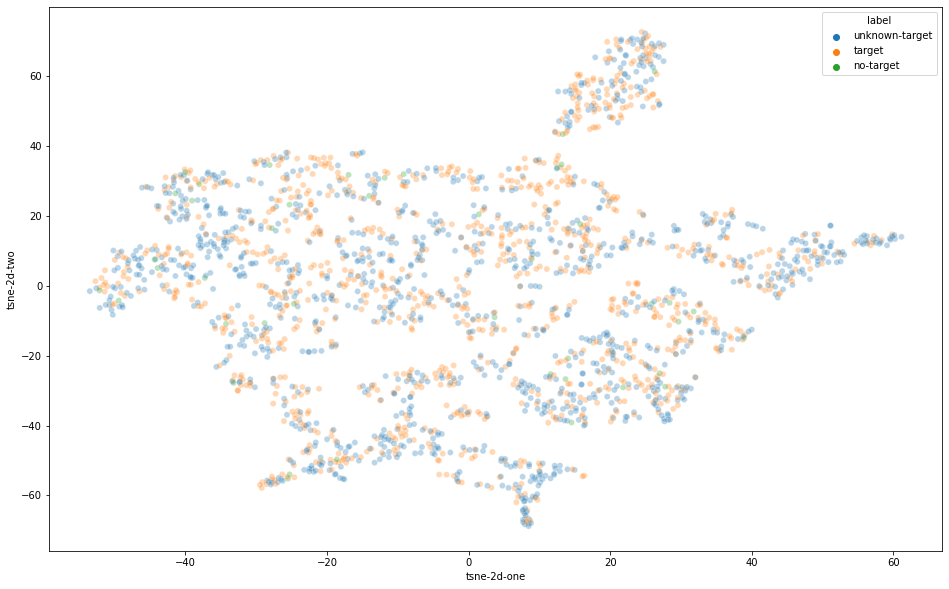

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    #palette=sns.color_palette("hls", 10),
    data=df.new,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[features].dropna())
df.new['pca-one'] = pca_result[:,0]
df.new['pca-two'] = pca_result[:,1] 
df.new['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.47222626 0.19043451 0.1855683 ]


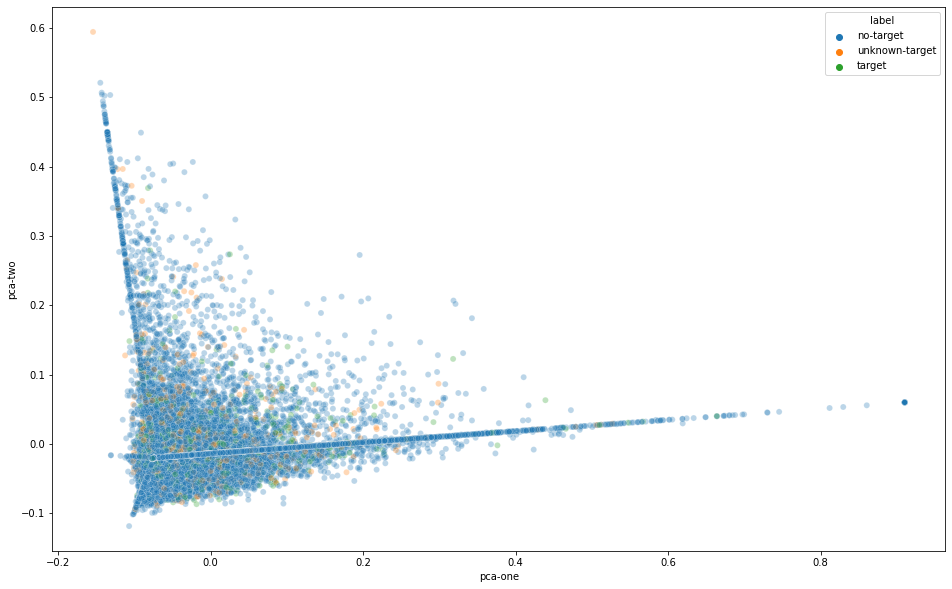

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    #palette=sns.color_palette("hls", 10),
    data=df.new,
    legend="full",
    alpha=0.3
)

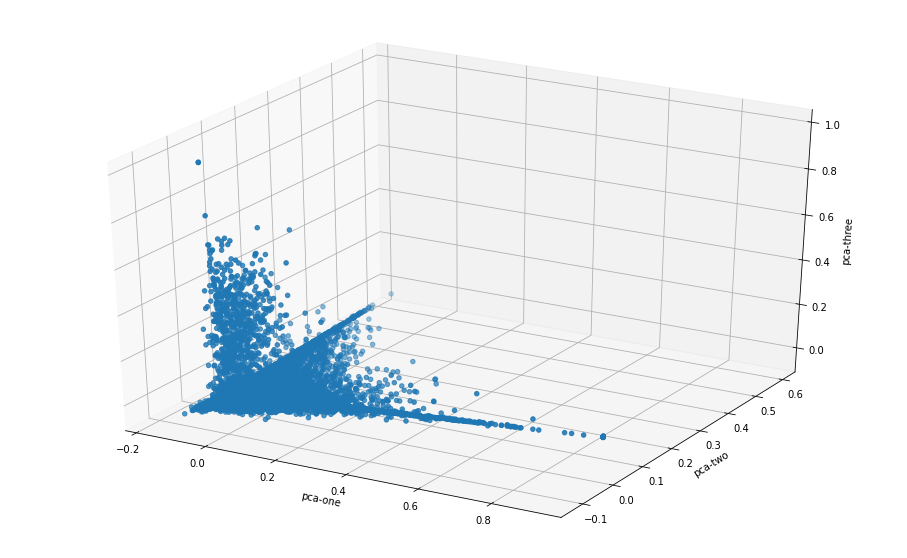

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.new["pca-one"], 
    ys=df.new["pca-two"], 
    zs=df.new["pca-three"], 
    #c=df.new["label"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
df = asso.merge(ground, how="inner", left_index=True, right_index=True)
df = df.reset_index(
                ).drop_duplicates(subset="index", keep="first"
                ).set_index("index"
                ).rename_axis("ensembl"
                )

pos = ['Clinical Trial target', 'Successful target', 'Patented target']
neg = ['Discontinued target']
unknown = [np.nan, 'Research target']

df["TARGETSTATUS"] = 0
df.loc[df.TARGTYPE.isin(pos), "TARGETSTATUS"] = "positive"
df.loc[df.TARGTYPE.isin(neg), "TARGETSTATUS"] = "negative"
df.loc[df.TARGTYPE.isin(unknown), "TARGETSTATUS"] = "unknown"
df.TARGETSTATUS.value_counts()

features = ['overall_score', 'affected_pathway_score', 'animal_model_score',
       'genetic_association_score', 'literature_score', 'rna_expression_score',
       'somatic_mutation_score']
X = df[features].dropna()
#X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)

df.new = X.copy()
df.new['tsne-2d-one'] = X_embedded[:,0]
df.new['tsne-2d-two'] = X_embedded[:,1]


df.new["label"] = df.loc[df.overall_score.notnull(), "TARGETSTATUS"]
df.new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,overall_score,affected_pathway_score,animal_model_score,genetic_association_score,literature_score,rna_expression_score,somatic_mutation_score,tsne-2d-one,tsne-2d-two,label
ensembl,,,,,,,,,,
ENSG00000000938,0.205693,0.046816,0.014386,0.010607,0.013633,0.002239,0.0,-8.879924,5.262681,unknown
ENSG00000000971,0.174999,0.000000,0.100980,0.074337,0.019032,0.001054,0.0,-32.522411,1.200360,positive
ENSG00000001626,0.175005,0.034716,0.083105,0.048796,0.028753,0.000813,0.0,-26.466227,5.815694,positive
ENSG00000001630,0.141748,0.003876,0.116442,0.016325,0.009885,0.000048,0.0,-41.828468,-10.496950,positive
ENSG00000002726,0.101118,0.010765,0.016202,0.051700,0.023692,0.003129,0.0,28.387833,-14.271199,unknown


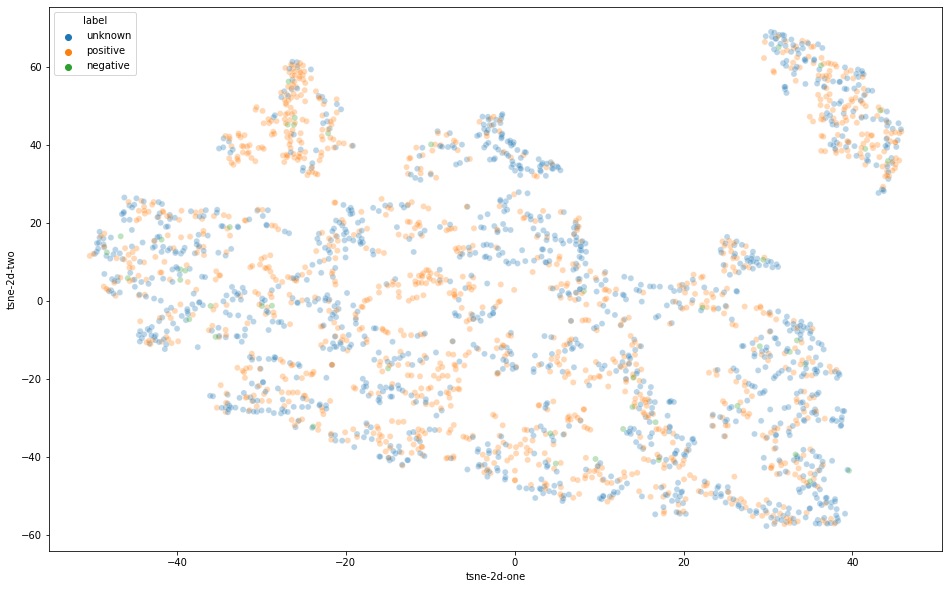

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    #palette=sns.color_palette("hls", 10),
    data=df.new,
    legend="full",
    alpha=0.3
)

In [ ]:
mg.getgene(55872, fields="ensembl,symbol,enzrezid")

{'_id': '55872',
 '_version': 3,
 'ensembl': {'gene': '55872',
  'transcript': '55872-1',
  'translation': [],
  'type_of_gene': 'tRNA'},
 'symbol': 'PBK'}

-1

In [ ]:
# generate connection to mygene API
mg = mygene.MyGeneInfo()
# clean gene symbols in a way that is convertable
label["SYMBOL"] = label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")
label.SYMBOL
# query for all the gene symbols in humans only
q = mg.querymany(map(str.upper,label.SYMBOL.to_list()), 
                 scopes="symbol",fields="symbol,ensembl,alias", species="human")

# from 1034 of 3473 genes were not found --> try to improve it via gene synonyms 
# 123 genes showed duplicats

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
mg.query("CTGF", scopes="symbol",fields="symbol,ensembl,alias", species="human")

{'hits': [{'_id': '8839',
   '_score': 6.2365184,
   'alias': ['CT58', 'CTGF-L', 'WISP2'],
   'ensembl': {'gene': 'ENSG00000064205',
    'protein': ['ENSP00000190983', 'ENSP00000361956', 'ENSP00000361959'],
    'transcript': ['ENST00000190983',
     'ENST00000372865',
     'ENST00000372868',
     'ENST00000465000',
     'ENST00000471629',
     'ENST00000497421'],
    'translation': [{'protein': 'ENSP00000361959', 'rna': 'ENST00000372868'},
     {'protein': 'ENSP00000361956', 'rna': 'ENST00000372865'},
     {'protein': 'ENSP00000190983', 'rna': 'ENST00000190983'}],
    'type_of_gene': 'protein_coding'},
   'symbol': 'CCN5'},
  {'_id': '8838',
   '_score': 3.9596813,
   'alias': ['LIBC', 'PPAC', 'PPD', 'PPRD', 'WISP-3', 'WISP3'],
   'ensembl': {'gene': 'ENSG00000112761',
    'protein': ['ENSP00000230529',
     'ENSP00000357653',
     'ENSP00000357655',
     'ENSP00000386467',
     'ENSP00000395928',
     'ENSP00000473777',
     'ENSP00000491774',
     'ENSP00000501404',
     'ENSP0000050

In [ ]:
len(q)

3475

In [ ]:
# create placeholder for lookup converter (gene symbol to ensemblID)
l = {}
# loop through synonym gene symbols if not found directly
ind=0
# count how many conversions were found via synonym but has no ensembl
no_ensembl = 0
# count how many conversions were not found
not_found = 0
# count how many conversions were found via synonym gene symbols
corrected = 0
# loop through all 3'475 queries (gene symbols from dataframe)
for i in q:
  # catch all the dict items
  item = i.items()
  # loop through items
  for n in item:
    # check the underlying query and archive it
    if n[0] == "query":
          a = n[1]
    else:
      # if the query for that certain gene symbol was not found
      if n[0] == 'notfound':
        print(a)
        # and the gene symbol did not contain "/" -> breaks the query
        if "/" not in a:
          # then try to query for the gene synonyms if available
          Q = mg.query(a, scopes="symbol",fields="symbol,ensembl,alias", species="human")
          ind= 0
          # loop through all gene synonym queries
          for L in Q["hits"]:
            #print(L.items())
            for k, v in L.items():
              # check if the gene symbol of the query was assigned as exact synonym match
              if k == "alias":
                if a in v:
                  # check if that gene synonym also contain a ensemblID
                  if "ensembl" in Q["hits"][ind].keys():
                    # if it has an ensemblID check if it is a list or a dict
                    if isinstance(Q["hits"][ind]["ensembl"], list):
                      # store the ensemblID
                      print(a, v, ind, Q["hits"][ind]["ensembl"][0])#["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"][0]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                    else:
                      # if the ensembl is a dict instead of a list
                      print(a, v, ind, Q["hits"][ind]["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                  else:
                    # if the gene synonym was found but there was not ensemblID
                    print(a, v, ind, Q["hits"][ind].keys())
                    b = "not-found"
                    l[a] = b
                    no_ensembl += 1

                ind += 1
          
          
        
        # b = n[0]
        # l[a] = b
    
      elif n[0] == "ensembl":
        try:
          b = n[1]["gene"]
        except:
          b = n[1][0]["gene"]
        l[a] = b
    

"from the 1037 genes {} were found via gene synonyms and {} are still not found".format(corrected, not_found)

FUNG
CTGF
CTGF ['CTGF', 'HCS24', 'IGFBP8', 'NOV2'] 2 ENSG00000118523
DMPK-LIKE
5-LOX
5-LOX ['5-LO', '5-LOX', '5LPG', 'LOG5'] 0 {'gene': 'ENSG00000012779', 'protein': ['ENSP00000363512', 'ENSP00000437634', 'ENSP00000483803'], 'transcript': ['ENST00000374391', 'ENST00000475300', 'ENST00000481117', 'ENST00000483623', 'ENST00000493336', 'ENST00000498461', 'ENST00000542434', 'ENST00000612635'], 'translation': [{'protein': 'ENSP00000363512', 'rna': 'ENST00000374391'}, {'protein': 'ENSP00000437634', 'rna': 'ENST00000542434'}, {'protein': 'ENSP00000483803', 'rna': 'ENST00000612635'}], 'type_of_gene': 'protein_coding'}
NFKB
BACT
ABL
HIV
BACT
GLUT9
GLUT9 ['GLUT6', 'GLUT9', 'HSA011372'] 0 {'gene': 'ENSG00000281165', 'protein': ['ENSP00000486637', 'ENSP00000486716', 'ENSP00000487067', 'ENSP00000487571'], 'transcript': ['ENST00000625425', 'ENST00000625489', 'ENST00000626271', 'ENST00000627289', 'ENST00000627959'], 'translation': [{'protein': 'ENSP00000487067', 'rna': 'ENST00000626271'}, {'protein':

(414, 19)

In [ ]:
# generate connection to mygene API
mg = mygene.MyGeneInfo()
# clean gene symbols in a way that is convertable
label["SYMBOL"] = label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")
label.SYMBOL
# query for all the gene symbols in humans only
q = mg.querymany(map(str.upper,label.SYMBOL.to_list()), 
                 scopes="symbol",fields="symbol,ensembl,alias", species="human",
                 returnall=True)

# from 1034 of 3473 genes were not found --> try to improve it via gene synonyms 
# 123 genes showed duplicates

# create placeholder for lookup converter (gene symbol to ensemblID)
l = {}
# loop through synonym gene symbols if not found directly
ind=0
# count how many conversions were found via synonym but has no ensembl
no_ensembl = 0
# count how many conversions were not found
not_found = 0
# count how many conversions were found via synonym gene symbols
corrected = 0
# count how many were not found before correction
uncorrected = 0

iterator = 0

# loop through all 3'475 queries (gene symbols from dataframe)
for i in q["out"]:
  # catch all the dict items
  item = i.items()
  # loop through items
  for n in item:
    # check the underlying query and archive it
    if n[0] == "query":
          a = n[1]
    else:
      # if the query for that certain gene symbol was not found
      if n[0] == 'notfound':
        #print(a)
        uncorrected += 1
        b = "not-found"
        l[a] = b
          
        # and the gene symbol did not contain "/" -> breaks the query
        if "/" not in a:
          # then try to query for the gene synonyms if available
          Q = mg.query(a, scopes="symbol",fields="symbol,ensembl,alias", species="human")
          ind= 0

          if Q["hits"] == []:
            not_found += 1
          # loop through all gene synonym queries
          for L in Q["hits"]:
            #print(L.items())
            for k, v in L.items():
              # check if the gene symbol of the query was assigned as exact synonym match
              if k == "alias":
                if a in v:
                  # check if that gene synonym also contain a ensemblID
                  if "ensembl" in Q["hits"][ind].keys():
                    # if it has an ensemblID check if it is a list or a dict
                    if isinstance(Q["hits"][ind]["ensembl"], list):
                      # store the ensemblID
                      #print(a, v, ind, Q["hits"][ind]["ensembl"][0])#["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"][0]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                    else:
                      # if the ensembl is a dict instead of a list
                      #print(a, v, ind, Q["hits"][ind]["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                  else:
                    # if the gene synonym was found but there was not ensemblID
                    #print(a, v, ind, Q["hits"][ind].keys())
                    
                    no_ensembl += 1
                    not_found += 1
                ind += 1
        else:
          # not found due to "/" in gene symbol breaks query
          not_found += 1
         
              
          
          
        
        # b = n[0]
        # l[a] = b
    
      elif n[0] == "ensembl":
        try:
          b = n[1]["gene"]
        except:
          b = n[1][0]["gene"]
        l[a] = b
    
      elif "ensembl" not in list(q["out"][iterator].keys()):
        print(n)
        b = "not-found"
        l[a] = b
        not_found +=1
        no_ensembl += 1
        uncorrected += 1

  iterator += 1    
# 1034 not found
# 123 showed duplicated queries
"from the {} missing genes {} were still found via gene synonyms and {} are still not found - However, from these {} - {} just don t have an ensemblID".format(uncorrected, corrected, uncorrected-corrected, uncorrected-corrected,no_ensembl)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',
('_id', '574')
('_score', 123.03218)
('alias', ['BAGE1', 'CT2.1'])
('symbol', 'BAGE')
('_id', '6957')
('_score', 119.07277)
('alias', ['TCRB', 'TRB@'])
('symbol', 'TRB')
('_id', '28639')
('_score', 116.46394)
('alias', ['BV05S1J2.2', 'TCRB', 'TCRBC1'])
('symbol', 'TRBC1')


'from the 1046 missing genes 414 were still found via gene synonyms and 632 are still not found - However, from these 632 - 31 just don t have an ensemblID'

In [ ]:
# generate connection to mygene API
mg = mygene.MyGeneInfo()
# clean gene symbols in a way that is convertable
label["SYMBOL"] = label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")
label.SYMBOL
# query for all the gene symbols in humans only
q = mg.querymany(map(str.upper,label.SYMBOL.to_list()), 
                 scopes="symbol",fields="symbol,ensembl,alias", species="human",
                 returnall=True)

# from 1034 of 3473 genes were not found --> try to improve it via gene synonyms 
# 123 genes showed duplicates

# create placeholder for lookup converter (gene symbol to ensemblID)
l = {}
# loop through synonym gene symbols if not found directly
ind=0
# count how many conversions were found via synonym but has no ensembl
no_ensembl = 0
# count how many conversions were not found
not_found = 0
# count how many conversions were found via synonym gene symbols
corrected = 0
# count how many were not found before correction
uncorrected = 0

iterator = 0

# loop through all 3'475 queries (gene symbols from dataframe)
for i in q["out"]:
  # catch all the dict items
  # loop through items
  key = [k for k in i.keys()]
  value = [v for v in i.values()]
  if "query" in key:
    a = value[key.index("query")]
  else:
    a = "no-query"
  
  if "ensembl" in key:
    try:
      b = value[key.index("ensembl")]["gene"]
    except:
      b = value[key.index("ensembl")][0]["gene"]
      l[a] = b

  else:    
    b = "no-ensembl"
    l[a] = b
    not_found +=1
    no_ensembl += 1
    uncorrected += 1

  if 'notfound' in key:
    uncorrected += 1
    b = "not-found"
    l[a] = b  
    # and the gene symbol did not contain "/" -> breaks the query
    if "/" not in a:
      # then try to query for the gene synonyms if available
      Q = mg.query(a, scopes="symbol",fields="symbol,ensembl,alias", species="human")
      ind= 0

      if Q["hits"] == []:
        not_found += 1
      # loop through all gene synonym queries
      for L in Q["hits"]:
        key2 = [k for k in L.keys()]
        value2 = [v for v in L.values()]
          # check if the gene symbol of the query was assigned as exact synonym match
        if "alias" in key2:
          if a in value2:
              # check if that gene synonym also contain a ensemblID
            if "ensembl" in key2:
              #print(value2[key2.index("ensembl")])
                # if it has an ensemblID check if it is a list or a dict
              if isinstance(value2[key2.index("ensembl")], list):
                  # store the ensemblID
                  #print(a, v, ind, Q["hits"][ind]["ensembl"][0])#["ensembl"]["gene"])
                b = value2[key2.index("ensembl")][0]["gene"]
                l[a] = b
                ind = 0
                corrected += 1
              else:
                  # if the ensembl is a dict instead of a list
                  #print(a, v, ind, Q["hits"][ind]["ensembl"]["gene"])
                b = value2[key2.index("ensembl")]["gene"]
                l[a] = b
                ind = 0
                corrected += 1
            else:
                # if the gene synonym was found but there was not ensemblID
                #print(a, v, ind, Q["hits"][ind].keys())
                
              no_ensembl += 1
              not_found += 1
          ind += 1
    else:
      # not found due to "/" in gene symbol breaks query
      not_found += 1
      
          
        
        
      
        # b = n[0]
        # l[a] = b
    
  iterator += 1    
# 1034 not found
# 123 showed duplicated queries
"from the {} missing genes {} were still found via gene synonyms and {} are still not found - However, from these {} - {} just don t have an ensemblID".format(uncorrected, corrected, uncorrected-corrected, uncorrected-corrected,no_ensembl)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',


'from the 2071 missing genes 24 were still found via gene synonyms and 2047 are still not found - However, from these 2047 - 1040 just don t have an ensemblID'

In [ ]:
pd.DataFrame([m]).T.value_counts()

In [ ]:
mg.query(not_found[1], scopes="symbol", fields="symbol,ensembl,alias", 
                   species="human")["hits"]

[{'_id': '8839',
  '_score': 6.2365184,
  'alias': ['CT58', 'CTGF-L', 'WISP2'],
  'ensembl': {'gene': 'ENSG00000064205',
   'protein': ['ENSP00000190983', 'ENSP00000361956', 'ENSP00000361959'],
   'transcript': ['ENST00000190983',
    'ENST00000372865',
    'ENST00000372868',
    'ENST00000465000',
    'ENST00000471629',
    'ENST00000497421'],
   'translation': [{'protein': 'ENSP00000361959', 'rna': 'ENST00000372868'},
    {'protein': 'ENSP00000361956', 'rna': 'ENST00000372865'},
    {'protein': 'ENSP00000190983', 'rna': 'ENST00000190983'}],
   'type_of_gene': 'protein_coding'},
  'symbol': 'CCN5'},
 {'_id': '8838',
  '_score': 3.9618757,
  'alias': ['LIBC', 'PPAC', 'PPD', 'PPRD', 'WISP-3', 'WISP3'],
  'ensembl': {'gene': 'ENSG00000112761',
   'protein': ['ENSP00000230529',
    'ENSP00000357653',
    'ENSP00000357655',
    'ENSP00000386467',
    'ENSP00000395928',
    'ENSP00000473777',
    'ENSP00000491774',
    'ENSP00000501404',
    'ENSP00000501523'],
   'transcript': ['ENST000002

In [ ]:
pd.DataFrame([l]).T.value_counts().value_counts() 

1      2304
649       1
3         1
dtype: int64

In [ ]:
len(set(list(l.keys()))) - len(set(list(map(str.upper, label.SYMBOL))))

2956

In [ ]:
[q["out"][i]["query"] for i in range(len(q["out"])) if q["out"][i]["query"] in list(map(str.upper, label.SYMBOL.to_list())) ]

['SPP1',
 'TGFA',
 'FUNG',
 'CTGF',
 'DMPK-LIKE',
 'PIGU',
 '5-LOX',
 'TRPC5',
 'MDM2',
 'NFKB',
 'IL4',
 'NR1D1',
 'MOG',
 'CHRNA5',
 'TMPRSS11D',
 'BACT',
 'ABL',
 'TNNC2',
 'HIV',
 'BACT',
 'SRR',
 'IL23R',
 'P2RY10',
 'ABCA1',
 'PAWR',
 'GLUT9',
 'DUSP9',
 'SLCO1A2',
 'JNK3',
 'SOX2',
 'MAP4K1',
 'FUT3',
 'KCNJ11',
 'COT',
 'CXCR1',
 'HCAR3',
 'PRKCE',
 'NTF4',
 'PHF8',
 'TYRP1',
 'HIV',
 'PBRM1',
 'ERN1',
 'WWP2',
 'CSF-1R',
 'SPAG6',
 'STK32B',
 'BCR-ABL',
 'BACE2',
 'TMPRSS2',
 'TSG101',
 'MALARIA',
 'SYVN1',
 'NAE',
 'GSTO-1',
 'CX59',
 'SGPL1',
 'CAT',
 'PML',
 'STAP-COC',
 'HHAT',
 'ADRA2C',
 'ITGB1',
 'MALARIA',
 'KLK2',
 'MALARIA',
 'RON',
 'PDE4D',
 'G4S',
 'GCLM',
 'STRE-COC',
 'IL35',
 'DPOL',
 'RUNX2',
 'KCNT1',
 'TNFSF13B',
 'TMEM219',
 'GHR',
 'BACT',
 'UTS2',
 'EIF2AK1',
 'EPHB1',
 'PIP5K3',
 'NNT',
 'CD2',
 'SCN4A',
 'D3R',
 'PTGES',
 'SLCO1B3',
 'PDXP',
 'HIV',
 'TF',
 'BIRC5',
 'BACT',
 'NOS2',
 'MGLUR3',
 'IRF1',
 'NTSR1',
 'CCR3',
 'ABCC9',
 'DMD',
 'IFNB1',
 'H

In [ ]:
len(set(list(map(str.upper, label.SYMBOL)))) - len(set([q["out"][i]["query"] for i in range(len(q["out"]))]))

0

In [ ]:
"SERT" in list(map(str.upper, label.SYMBOL.to_list()))

True

In [ ]:
len(label)

3473

In [ ]:
q = mg.querymany(map(str.upper,label.SYMBOL.to_list()), 
                 scopes="symbol",fields="symbol,ensembl,alias", species="human",
                 returnall=True)


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',


In [ ]:
# create placeholder for lookup converter (gene symbol to ensemblID)
l = {}
# loop through synonym gene symbols if not found directly
ind=0
# count how many conversions were found via synonym but has no ensembl
no_ensembl = 0
# count how many conversions were not found
not_found = 0
# count how many conversions were found via synonym gene symbols
corrected = 0
# count how many were not found before correction
uncorrected = 0

iterator = 0

# loop through all 3'475 queries (gene symbols from dataframe)
for i in q["out"]:
  # catch all the dict items
  item = i.items()
  # loop through items
  for n in item:
    # check the underlying query and archive it
    if n[0] == "query":
          a = n[1]
    else:
      # if the query for that certain gene symbol was not found
      if n[0] == 'notfound':
        #print(a)
        uncorrected += 1
        b = "not-found"
        l[a] = b
          
        # and the gene symbol did not contain "/" -> breaks the query
        if "/" not in a:
          # then try to query for the gene synonyms if available
          Q = mg.query(a, scopes="symbol",fields="symbol,ensembl,alias", species="human")
          ind= 0

          if Q["hits"] == []:
            not_found += 1
          # loop through all gene synonym queries
          for L in Q["hits"]:
            #print(L.items())
            for k, v in L.items():
              # check if the gene symbol of the query was assigned as exact synonym match
              if k == "alias":
                if a in v:
                  # check if that gene synonym also contain a ensemblID
                  if "ensembl" in Q["hits"][ind].keys():
                    # if it has an ensemblID check if it is a list or a dict
                    if isinstance(Q["hits"][ind]["ensembl"], list):
                      # store the ensemblID
                      #print(a, v, ind, Q["hits"][ind]["ensembl"][0])#["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"][0]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                    else:
                      # if the ensembl is a dict instead of a list
                      #print(a, v, ind, Q["hits"][ind]["ensembl"]["gene"])
                      b = Q["hits"][ind]["ensembl"]["gene"]
                      l[a] = b
                      ind = 0
                      corrected += 1
                  else:
                    # if the gene synonym was found but there was not ensemblID
                    #print(a, v, ind, Q["hits"][ind].keys())
                    
                    no_ensembl += 1
                    not_found += 1
                ind += 1
        else:
          # not found due to "/" in gene symbol breaks query
          not_found += 1
         
              
          
          
        
        # b = n[0]
        # l[a] = b
    
      elif n[0] == "ensembl":
        try:
          b = n[1]["gene"]
        except:
          b = n[1][0]["gene"]
        l[a] = b
    
      elif "ensembl" not in list(q[iterator].keys()):
        print(n)
        b = "not-found"
        l[a] = b
        not_found +=1
        no_ensembl += 1
        uncorrected += 1

  iterator += 1    
# 1034 not found
# 123 showed duplicated queries
"from the {} missing genes {} were still found via gene synonyms and {} are still not found - However, from these {} - {} just don t have an ensemblID".format(uncorrected, corrected, uncorrected-corrected, uncorrected-corrected,no_ensembl)

In [ ]:
len([ l[i] for i in q["missing"] if "ENS" in l[i]  ])

333

In [ ]:
list(set(label.symbol.to_list())-set(list(l.keys())))


AttributeError: ignored

In [ ]:
pd.DataFrame([l]).T.value_counts().value_counts()

1      2543
2        42
329       1
dtype: int64

In [ ]:
mg.querymany(["TRB", "BAGE"], scopes="symbol",fields="symbol,ensembl,alias", species="human")

querying 1-2...done.
Finished.


[{'_id': '6957',
  '_score': 119.0701,
  'alias': ['TCRB', 'TRB@'],
  'query': 'TRB',
  'symbol': 'TRB'},
 {'_id': '574',
  '_score': 122.99864,
  'alias': ['BAGE1', 'CT2.1'],
  'query': 'BAGE',
  'symbol': 'BAGE'}]

196

In [ ]:
"from the 1037 genes {} were found via gene synonyms and {} are still not found".format(corrected, not_found)

'from the 1037 genes 414 were found via gene synonyms and 19 are still not found'

In [ ]:
mg.query("TLR2", scopes="symbol",fields="symbol,ensembl,alias", species="human")["hits"]

[{'_id': '7097',
  '_score': 449.61734,
  'alias': ['CD282', 'TIL4'],
  'ensembl': {'gene': 'ENSG00000137462',
   'protein': ['ENSP00000260010',
    'ENSP00000493968',
    'ENSP00000494425',
    'ENSP00000494668',
    'ENSP00000495339',
    'ENSP00000496208',
    'ENSP00000496676'],
   'transcript': ['ENST00000260010',
    'ENST00000642580',
    'ENST00000642700',
    'ENST00000643087',
    'ENST00000643501',
    'ENST00000645889',
    'ENST00000646219',
    'ENST00000646900'],
   'translation': [{'protein': 'ENSP00000493968', 'rna': 'ENST00000646900'},
    {'protein': 'ENSP00000496676', 'rna': 'ENST00000646219'},
    {'protein': 'ENSP00000495339', 'rna': 'ENST00000642580'},
    {'protein': 'ENSP00000496208', 'rna': 'ENST00000643501'},
    {'protein': 'ENSP00000494425', 'rna': 'ENST00000642700'},
    {'protein': 'ENSP00000260010', 'rna': 'ENST00000260010'},
    {'protein': 'ENSP00000494668', 'rna': 'ENST00000643087'}],
   'type_of_gene': 'protein_coding'},
  'symbol': 'TLR2'},
 {'_id':

In [ ]:
Q = mg.query("CTGF", scopes="symbol",fields="symbol,ensembl,alias", species="human")
n = 0
for L in Q["hits"]:
  #print(L.items())
  for k, v in L.items():
    
    if k == "alias":
      
      if "CTGF" in v:    
        print(Q["hits"][2]["ensembl"]["gene"])
      
      n += 1



ENSG00000118523


In [ ]:
Q["hits"][2]

{'_id': '1490',
 '_score': 3.9226396,
 'alias': ['CTGF', 'HCS24', 'IGFBP8', 'NOV2'],
 'ensembl': {'gene': 'ENSG00000118523',
  'protein': 'ENSP00000356954',
  'transcript': 'ENST00000367976',
  'translation': [{'protein': 'ENSP00000356954', 'rna': 'ENST00000367976'}],
  'type_of_gene': 'protein_coding'},
 'symbol': 'CCN2'}

In [ ]:
#label["symbol"]
label["ensemblID"] = list(map(str.upper, label.SYMBOL.to_list()))

label.ensemblID.replace(l, inplace=True)
label.head()

,TARGETID,TARGNAME,TARGTYPE,UNIPROID,SYMBOL,symbol,ensemblID
T00032,T00032,Osteopontin (SPP1),Research target,OSTP_HUMAN,SPP1,SPP1,ENSG00000118785
T00033,T00033,Transforming growth factor alpha (TGFA),Clinical Trial target,TGFA_HUMAN,TGFA,TGFA,ENSG00000163235
T00037,T00037,Fungal Sterol 24-C-methyltransferase (Fung erg6),Research target,ERG6_PNEC8,Fung,FUNG,notfound
T00039,T00039,CTGF messenger RNA (CTGF mRNA),Clinical Trial target,CTGF_HUMAN,CTGF,CTGF,notfound
T00075,T00075,CDC42 binding protein kinase alpha (DMPK-like ...,Research target,MRCKA_HUMAN,DMPK-like,DMPK-LIKE,notfound


In [ ]:
mg.MyGeneInfo()

AttributeError: ignored